In [1]:
import sys
import pandas as pd
import numpy as np

# Define a random seed for reproducibility
seed = 0
np.random.seed(seed)

import sklearn
import xgboost
import keras
import tensorflow as tf

import os
import pickle


print('Python: {}'.format(sys.version))
print('Pandas: {}'.format(pd.__version__))
print('Numpy: {}'.format(np.__version__))
print('Sklearn: {}'.format(sklearn.__version__))
print('XGBoost: {}'.format(xgboost.__version__))
print('Keras: {}'.format(keras.__version__))

Using TensorFlow backend.


Python: 3.6.10 |Anaconda, Inc.| (default, May  7 2020, 19:46:08) [MSC v.1916 64 bit (AMD64)]
Pandas: 1.0.3
Numpy: 1.18.1
Sklearn: 0.22.1
XGBoost: 1.1.1
Keras: 2.3.1


In [2]:
# import the processed dataset
df = pd.read_csv('../data/processed/NSQIP_Clean2.csv')
data = df
data = data.drop(columns=['index.1', 'index', 'Unnamed: 0']).copy()
# Replace missing values with median values
data['AGE'].replace(np.NaN, data['AGE'].median(), inplace=True)
data = data.dropna()

# create training and testing datasets
from sklearn.model_selection import train_test_split

features = data.drop(columns=['READMISSION1'])
labels = data.READMISSION1

X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size = 300, random_state = 0)

In [3]:
# load all optimized models from the models folder

dirName = '../models/'

fileList = list()
dirList = list()

for (dirpath, dirnames, filenames) in os. walk(dirName):
    for file in filenames:
        if '.sav' in file:
            fileList.append(os.path. join(dirpath, file))

modelList = list()

for file in fileList:
    model = pickle.load(open(file, 'rb'))
    modelList.append(model)

In [261]:
def bootstrap_roc_curves(model, X_test, Y_test):
    # predict probabilities
    lr_probs = model.predict_proba(X_test)

    # keep probabilities for the positive outcome only
    lr_probs = [round(x,2) for x in lr_probs[:, 1]]
    
    n_bootstraps = 1000
    rng_seed = 42# control reproducibility
    bootstrapped_scores = []
    fprList = []
    tprList = []

    rng = np.random.RandomState(rng_seed)
    for i in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        indices = rng.randint(0, len(lr_probs), len(lr_probs))
        if len(np.unique(np.array(Y_test)[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            # to be defined: reject the sample
            continue

        labels = np.array(Y_test)[indices]
        predictions = np.array(lr_probs)[indices]

        # calculate scores and curve
        bootstrapped_scores.append(sklearn.metrics.roc_auc_score(labels, predictions))
        lr_fpr, lr_tpr, _ = sklearn.metrics.roc_curve(labels, predictions, drop_intermediate=True)
        
        for value in lr_fpr:
            fprList.append(round(value,2))
        for value in lr_tpr:
            tprList.append(round(value,2))
    
    return fprList, tprList, bootstrapped_scores

In [301]:
lr_probs = model.predict_proba(X_test)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

lr_fpr, lr_tpr, _ = sklearn.metrics.roc_curve(Y_test, lr_probs, drop_intermediate=False)

In [298]:
import seaborn as sns

fpr, tpr, scores = bootstrap_roc_curves(modelList[1], X_test, Y_test)

data = pd.DataFrame(list(zip(fpr,tpr,scores)), columns=['fpr','tpr','scores'])
new = data.sort_values('scores', ignore_index=True).copy()

In [299]:
clean = data[data['fpr'].isin([round(x,2) for x in np.linspace(0,1,21)])].copy()

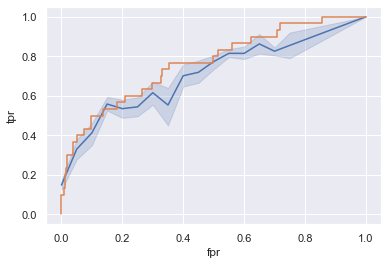

In [302]:
sns.lineplot(x='fpr', y='tpr', data=clean)
plt.plot(lr_fpr, lr_tpr)

No handles with labels found to put in legend.


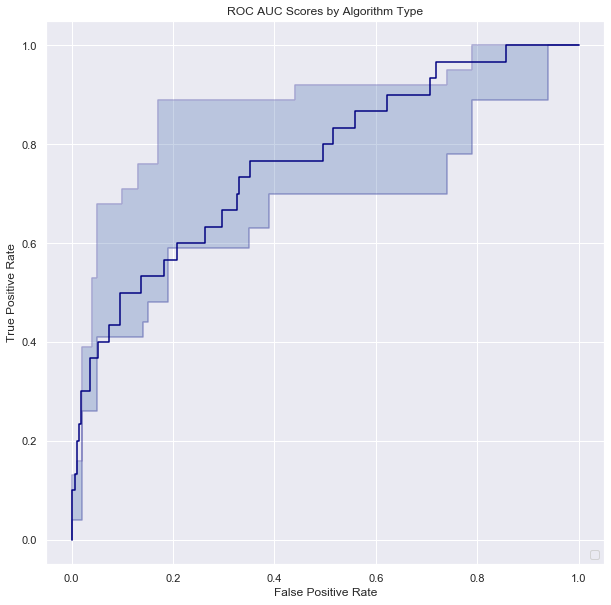

In [311]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
cmap = plt.get_cmap('tab10')
plt.plot(lower['fpr'], lower['tpr'], color='navy', alpha=0.3)
plt.plot(upper['fpr'], upper['tpr'], color='navy', alpha=0.3)
plt.plot(lr_fpr, lr_tpr, color='navy')

plt.fill(np.append(lower['fpr'], upper['fpr'][::-1]), np.append(lower['tpr'], upper['tpr'][::-1]), alpha=0.3)

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# title
plt.title('ROC AUC Scores by Algorithm Type')
# show the legend
plt.legend(loc = 'lower right')
# show the plot
plt.show()

In [4]:
import matplotlib.pyplot as plt

def generate_roc_curves(models, names, X_test, Y_test):
    
    plt.figure(figsize=(10,10))
    cmap = plt.get_cmap('tab10')
    
    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(Y_test))]
    
    for i,model in enumerate(models):
        
        # predict probabilities
        lr_probs = model.predict_proba(X_test)
        
        # keep probabilities for the positive outcome only
        lr_probs = lr_probs[:, 1]
        
        # calculate scores and curve
        lr_auc = sklearn.metrics.roc_auc_score(Y_test, lr_probs)
        lr_fpr, lr_tpr, _ = sklearn.metrics.roc_curve(Y_test, lr_probs)
        
        # plot the roc curve for the model
        plt.plot(lr_fpr, lr_tpr, color=cmap(0.1*i), marker='', label='{} (AUC = {})'.format(names[i], round(lr_auc,3)))
    
    # plot the roc curve for the no skill model
    ns_fpr, ns_tpr, _ = sklearn.metrics.roc_curve(Y_test, ns_probs)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', color='black', label='No Skill (AUC = 0.500)')
    
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    # title
    plt.title('ROC AUC Scores by Algorithm Type')
    # show the legend
    plt.legend(loc = 'lower right')
    # show the plot
    plt.show()
    
    return None

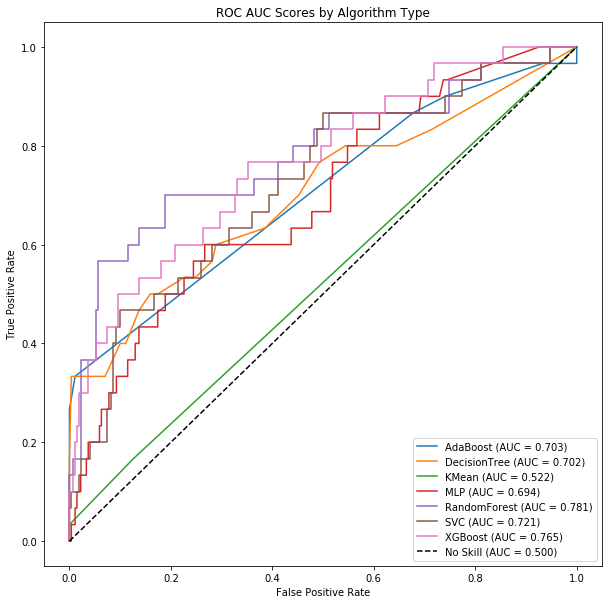

In [5]:
index = [file.split('/')[-1].rstrip('.sav') for file in fileList]
generate_roc_curves(modelList, index, X_test, Y_test)